# SI 370 - Homework 4: Hypothesis Testing and Regression Diagnostic

## Objectives
* Contingency tables, mosaic plots, $\chi^2$
Numerical analysis
* Visual: violin, box, CI
* Non-visual: t-test, ANOVA
* Outliers and Leverage points.,
* DFITTS,
* Generating and interpreting diagnostic regression plots,
* Cleaning outliers,
* Normalization by max value.

## Please fill in...
### * Your name: William Juang 
### * People you worked with:  [If you didn't work with anyone, write "I worked by myself" here]

## **Submission Instructions:**
After completing this homework, you should turn in two files via SI 370 001 WN 2017 > Assignments:
1. A Jupyter Notebook file named hw4-YOUR_UNIQUE_NAME.ipynb.  Please observe the following requirements:
    * This file should show all of the required work, including code, results, visualizations (if any), and necessary comments to your code.
    * You should use Markdown cells to enclose all textual content, including explanations, discoveries, and conclusions. Do not include such content unless required.
    * Irrelevant code and results should be deleted prior to submission.
2. An html file named hw4-YOUR_UNIQUE_NAME.html showing the preview of the above Jupyter Notebook. To create this file, select File > Download as HTML. We want this in case something breaks when we load your notebook.  This will let us see what you saw when you were done.

# Load everything up that we need

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
sns.set_context("notebook")  # make figures fit
from pylab import rcParams
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic
from IPython.display import Image
from IPython.core.display import HTML 
from pandas.core import datetools

# make the Pandas tables a little more readable

from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

# 1- Categorical Data Analysis

We want to return to the comic characters dataset and continue our analysis. So, go to SI 370 001 WN 2017 > Files > Datasets, and download "comic_characters.csv". Import it into your Jupyter Notebook as a Pandas DataFrame.

This time, we want to determine if comic books have any preference/bias for combination of sex and alignment (called "align" in our table). That is, whether they are biased in whether males or females are assigned heroic (good), villainous (bad), or netural roles. Note that because of lack of enough observations, we want to restrict sex to only female and male characters, and alignment to only good, bad, and neutral characters.

In [6]:
# Import Data
comicCharacters = pd.DataFrame.from_csv('comic_characters.csv', index_col="id")
comicCharacters['align'].unique()

array(['Good Characters', 'Neutral Characters', 'Bad Characters', nan,
       'Reformed Criminals'], dtype=object)

### 1(a) Restrict the dataframe to only female and male, and good, bad, and neutral characters.

In [7]:
cc = comicCharacters[(comicCharacters.sex == "Male Characters") | (comicCharacters.sex == 'Female Characters')]
cc = cc[(cc['align'] == "Good Characters") | (cc['align'] == "Bad Characters") | (cc['align'] == "Neutral Characters")]
cc.head()

,publisher,name,Identity,align,eye,hair,sex,alive,appearances,first_appearance,month,year,date
id,,,,,,,,,,,,,
1,Marvel,Spider-Man (Peter Parker),Secret Identity,Good Characters,Hazel Eyes,Brown Hair,Male Characters,Living Characters,4043.0,"1962, August",August,1962.0,8/1/1962
2,Marvel,Captain America (Steven Rogers),Public Identity,Good Characters,Blue Eyes,White Hair,Male Characters,Living Characters,3360.0,"1941, March",March,1941.0,3/1/1941
3,Marvel,"Wolverine (James \""Logan\"" Howlett)",Public Identity,Neutral Characters,Blue Eyes,Black Hair,Male Characters,Living Characters,3061.0,"1974, October",October,1974.0,10/1/1974
4,Marvel,"Iron Man (Anthony \""Tony\"" Stark)",Public Identity,Good Characters,Blue Eyes,Black Hair,Male Characters,Living Characters,2961.0,"1963, March",March,1963.0,3/1/1963
5,Marvel,Thor (Thor Odinson),No Dual Identity,Good Characters,Blue Eyes,Blond Hair,Male Characters,Living Characters,2258.0,"1950, November",November,1950.0,11/1/1950


### 1(b) We need to generate a contingency table of sex, and align(ment). Create a version without the totals row/column first and keep that around (give it a name like comicCrosstab, you'll need it later)

In [8]:
comicCrosstab = cc.groupby(['sex', 'align']).size().to_frame()
comicCrosstab = comicCrosstab.unstack('align')
comicCrosstab

0                                   
align             Bad Characters Good Characters Neutral Characters
sex                                                                
Female Characters           1573            2490                836
Male Characters             7561            4809               1799

### 1(c) Generate a mosaic plot of the contingency table. Report patterns you are seeing in the data?

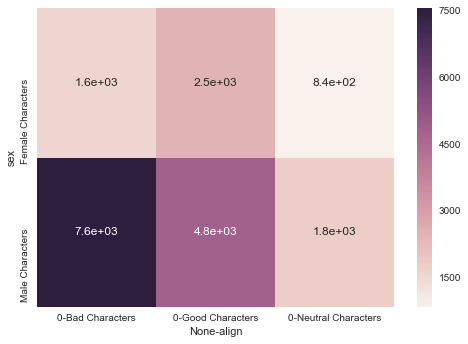

In [9]:
sns.heatmap(comicCrosstab, annot=True)

#the number of male characters that are bad is significantly higher than the number of female characters that are bad
#female characters are most likely to be good
#male characters are most likely to be bad

### 1(d) Now, we want to use scipy.stats.chi2_contingency() run $\chi^2$ test on the observations, generate the expected table, and explain the results. Then interpret the results. You can use the information from your table and plot above.

In [10]:
chi2, p, dof, ex = stats.chi2_contingency(comicCrosstab)
print("chi2 = ", chi2)
print("p-val = ", p)
print("degree of freedom = ", dof)
print("Expected: ", ex)

# These statistics tell us that if the distribution of this data is due entirely to chance, then you have a 4.48664243309e-143% 
# chance of finding a discrepancy between the observed and expected distributions that is at least this extreme. In addition, 
# this means that the null hypothesis that the  has a very small chance of being correct.

chi2 =  664.7474677
p-val =  4.48664243309e-145
degree of freedom =  2
Expected:  [[ 2346.73096287  1875.27800503   676.9910321 ]
 [ 6787.26903713  5423.72199497  1958.0089679 ]]


### 1(extra-credit): We would like to understand if publishers vary by the way they assign male/female/good/bad/netural.  Perform the analysis as above, this time using publisher as the "row." (a mosaic plot may not be so helpful here).

# 2- Boxplot, Violin Plot, & Confidence Intervals

Load the Iris dataset.

In [11]:
# load Iris data file
df = sns.load_dataset('iris')

df.sample(10)

,sepal_length,sepal_width,petal_length,petal_width,species
82,5.8,2.7,3.9,1.2,versicolor
19,5.1,3.8,1.5,0.3,setosa
27,5.2,3.5,1.5,0.2,setosa
141,6.9,3.1,5.1,2.3,virginica
110,6.5,3.2,5.1,2.0,virginica
146,6.3,2.5,5.0,1.9,virginica
25,5.0,3.0,1.6,0.2,setosa
128,6.4,2.8,5.6,2.1,virginica
48,5.3,3.7,1.5,0.2,setosa
142,5.8,2.7,5.1,1.9,virginica


### 2(a) Create a dataframe with three columns: each should be the petal length for each of the three species (there are 50 of each, so you should end up with 50 rows)

In [12]:
pl_df = pd.DataFrame()
pl = df[["species", "petal_length"]]
pl_setosa = pl[pl.species == "setosa"]
pl_versicolor = pl[pl.species == "versicolor"]
pl_virginica = pl[pl.species == "virginica"]
for i in pl:
    for row in pl[i]:
        if row == "setosa":
            pl_df['setosa'] = pl_setosa.petal_length
        if row == "versicolor":
            pl_df['versicolor'] = pl_versicolor.reset_index().petal_length
        if row == "virginica":
            pl_df['virginica'] = pl_virginica.reset_index().petal_length
pl_df


,setosa,versicolor,virginica
0,1.4,4.7,6.0
1,1.4,4.5,5.1
2,1.3,4.9,5.9
3,1.5,4.0,5.6
4,1.4,4.6,5.8
5,1.7,4.5,6.6
6,1.4,4.7,4.5
7,1.5,3.3,6.3
8,1.4,4.6,5.8
9,1.5,3.9,6.1


### 2(b) Create a boxplot comparing petal_length for the three species. Overlay data points over the boxes (remember if you call seaborn plots twice in a cell it will overlay one plot on the other). Describe what you're seeing (as differences).  Do you see outliers?

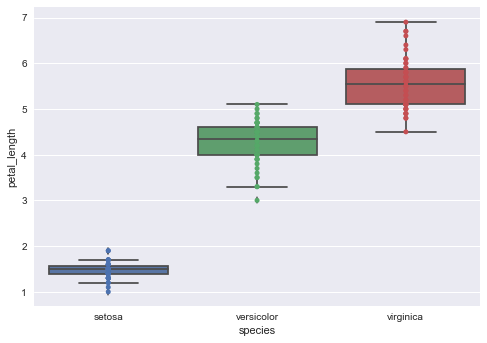

In [13]:
twob = df[["species", "petal_length"]]
ax = sns.stripplot(x="species", y="petal_length", data=twob)
ax = sns.boxplot(pl_df)
# I see two outliers, there is an outlier that is flower that has a petal length lower than the average versicolor flower. 
# There is also another outlier in the setosa family that has a significantly higher petal length than average

### 2(c) Now, let's try using violin plots of the same series. Explain what you're seeing that's different than the boxplot.

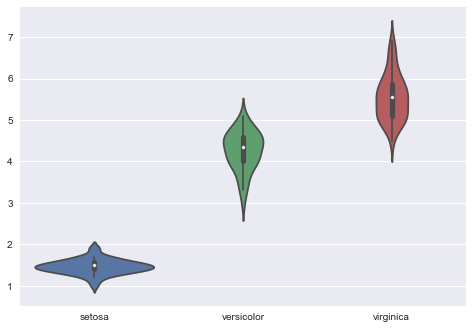

In [14]:
sns.violinplot(pl_df)

# With the box plot you do not see any horizontal differents in the data. However, with the violin plot you can see the 
# horizontal distributions of each of the flower types as well.

### 2(d): Draw the data with confidence intervals.  Interpret what you're seeing.  Should you expect a statistically significant result? Why?

### 2(e): Calculate an ANOVA for your three series. What can we conclude about petal length in the three species? 

In [15]:
stats.f_oneway(pl_df.setosa.dropna(), pl_df.versicolor.dropna(), pl_df.virginica.dropna())

# From the ANOVA test from the three series, we can conlcude that the petal_lengths of the three species are signifcantly
# different from one another

F_onewayResult(statistic=1180.161182252981, pvalue=2.8567766109615584e-91)

# 3. *t*-test

Load the t-test.csv dataset from SI 370 001 WN 2017 > Files > Datasets. Set p-value threshold $\alpha=5\%$.

In [16]:
df = pd.DataFrame.from_csv('t-test.csv')
df.head()

,X1,X2
0,-2.761583,0.718488
1,-6.239159,-1.216925
2,-4.447703,1.229384
3,0.069537,0.323164
4,-2.930666,0.045891


### 3(a)  Plot the distributions of X1 and X2. What can you determine from the plot?

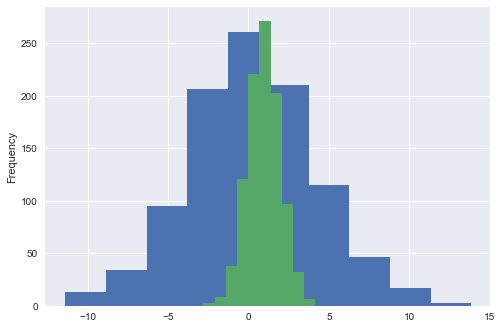

In [17]:
df.X1.plot(kind='hist')
df.X2.plot(kind='hist')

# They are both normally distributed

### 3(b) Plot a confidence interval plot? Are the differences likely to be significant? At what level?

[ 0.002856    0.50711536]
[ 0.8928405   1.01868033]


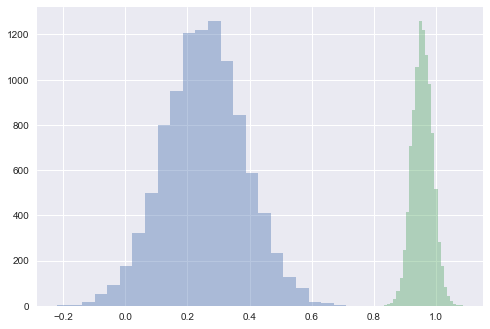

In [18]:
reps = 10000
xb = np.random.choice(df.X1, (len(df.X1), reps))
mb = xb.mean(axis = 0)
mb.sort()
ptile = np.percentile(mb, [2.5, 97.5])
print(ptile)
ax = sns.distplot(mb, 25, kde=False)

xb1 = np.random.choice(df.X2, (len(df.X2), reps))
mb1 = xb1.mean(axis = 0)
mb1.sort()
ptile = np.percentile(mb1, [2.5, 97.5])
print(ptile)
ax = sns.distplot(mb1, 25, kde=False)

# Given that the plots for both graphs do not overlap the differences are likely to be significant at every level

### 3(c)  Perform a t-test for the null hypothesis that X1 and X2 have identical mean value. Then interpret the results.

In [19]:
stats.ttest_ind(mb, mb1)
# The p-value is 0.0, which means that there is no probability that X1 and X2 have an identical mean value

Ttest_indResult(statistic=-533.86961385629934, pvalue=0.0)

# 4. Outliers

### 4(a) Load the dataset outliers.csv and plot its scatterplot. Then, only based on the scatterplot, identify the influence, leverage, and outlier points. You can annotate the plot directly by first drawing the seaborn plot (e.g., ax = sns...) and then using ax.text(...).

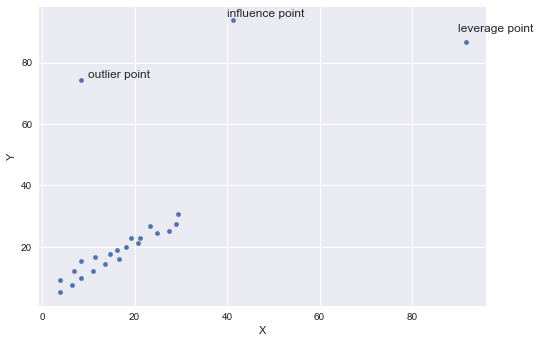

In [20]:
# load outliers data file
outliers = pd.DataFrame.from_csv('outliers.csv')
ax = outliers.plot(kind='scatter', x='X', y='Y')
ax.text(x=40, y=95, s = "influence point")
ax.text(x=90, y=90, s = "leverage point")
ax.text(x=10, y=75, s = "outlier point")

### 4(b) Calculate a regression (simple, linear) between X and Y. Find the points with the DFFITS Distance that exceeds the threshold for high influence?

In [26]:
fourb_plot = smf.ols('X ~ Y', data=outliers).fit()
print (fourb_plot.summary())
infl = fourb_plot.get_influence()
infl_stats = infl.summary_frame()
infl_stats.sort_values('dffits', ascending=False)

print(2*sqrt(k / len(outliers)))
# 

                            OLS Regression Results                            
Dep. Variable:                      X   R-squared:                       0.515
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                     23.36
Date:                Thu, 31 Aug 2017   Prob (F-statistic):           7.89e-05
Time:                        11:52:21   Log-Likelihood:                -94.083
No. Observations:                  24   AIC:                             192.2
Df Residuals:                      22   BIC:                             194.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.6131      3.929      1.429      0.1

NameError: name 'sqrt' is not defined

### 4(c) Visualize DFFITS Distance. Draw a horizontal line  (or two) at the threshold (hint: use plt.hlines). How many points fall above the threshold?

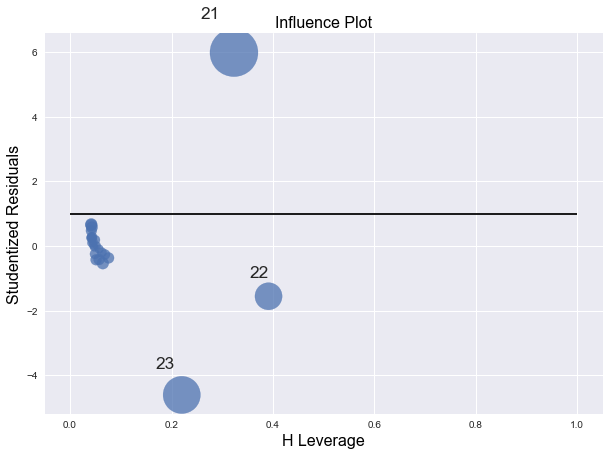

In [27]:
fig, ax = plt.subplots(figsize=(10,7))
fig = sm.graphics.influence_plot(fourb_plot, ax=ax, criterion='dffits')
plt.hlines(xmin=0, xmax=1, y=1)

#  

### 4(d) Remove the outlier(s) that you found using DFFITS Distance (and the threshold). Calculate a new simple linear model based on this data.

ValueError: x and y must have same first dimension, but have shapes (19068, 13) and (24,)

### 4(e) Plot the old and new regression lines together. Report your observations in the worksheet.

### 4(f) Create code to normalize the cleaned (outliers removed) X values to [0, 1]. Plot the original and the normalized datasets.